In [61]:
%matplotlib inline
import sklearn.datasets as ds
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GSCV, RandomizedSearchCV as RSCV, cross_val_score as cvs, KFold

In [30]:
data = ds.fetch_california_housing(data_home='./assets', as_frame=True)
data_frame = data.frame
X = data_frame.drop(data.target_names, axis = 1).copy()
Y = data_frame[data.target_names]
data_frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Data Characteristics
The Data Above contains 8 features and one target. Let us check for null values.

In [31]:
data_frame[data_frame.isna().any(axis = 1)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal


## Results of Null Checking
Checking for null values shows that the data does not contain any null values. Since the data is already in matrix form, we will not perform any preprocessing. The data is already preprocessed. Next we extract features and target from the data frame. Then use Standard Scaler to enforce gaussian discribution and PCA for dimensionality reduction and feature extraction.

In [32]:
scaled_X = StandardScaler().fit_transform(X)
pca = PCA(0.9)
features = pca.fit_transform(scaled_X)
print('Number of Components:', pca.n_components_)
print('Variance Percentages:', pca.explained_variance_ratio_)
print('Variance:', pca.explained_variance_)

Number of Components: 5
Variance Percentages: [0.25336868 0.23516245 0.15888635 0.12887971 0.12538195]
Variance: [2.02704763 1.88139074 1.27115235 1.03108764 1.0031042 ]


## Feature Extraction
After performing scaling and feature extraction with PCA and 90% variance, 5 features were extracted with the above variance each.

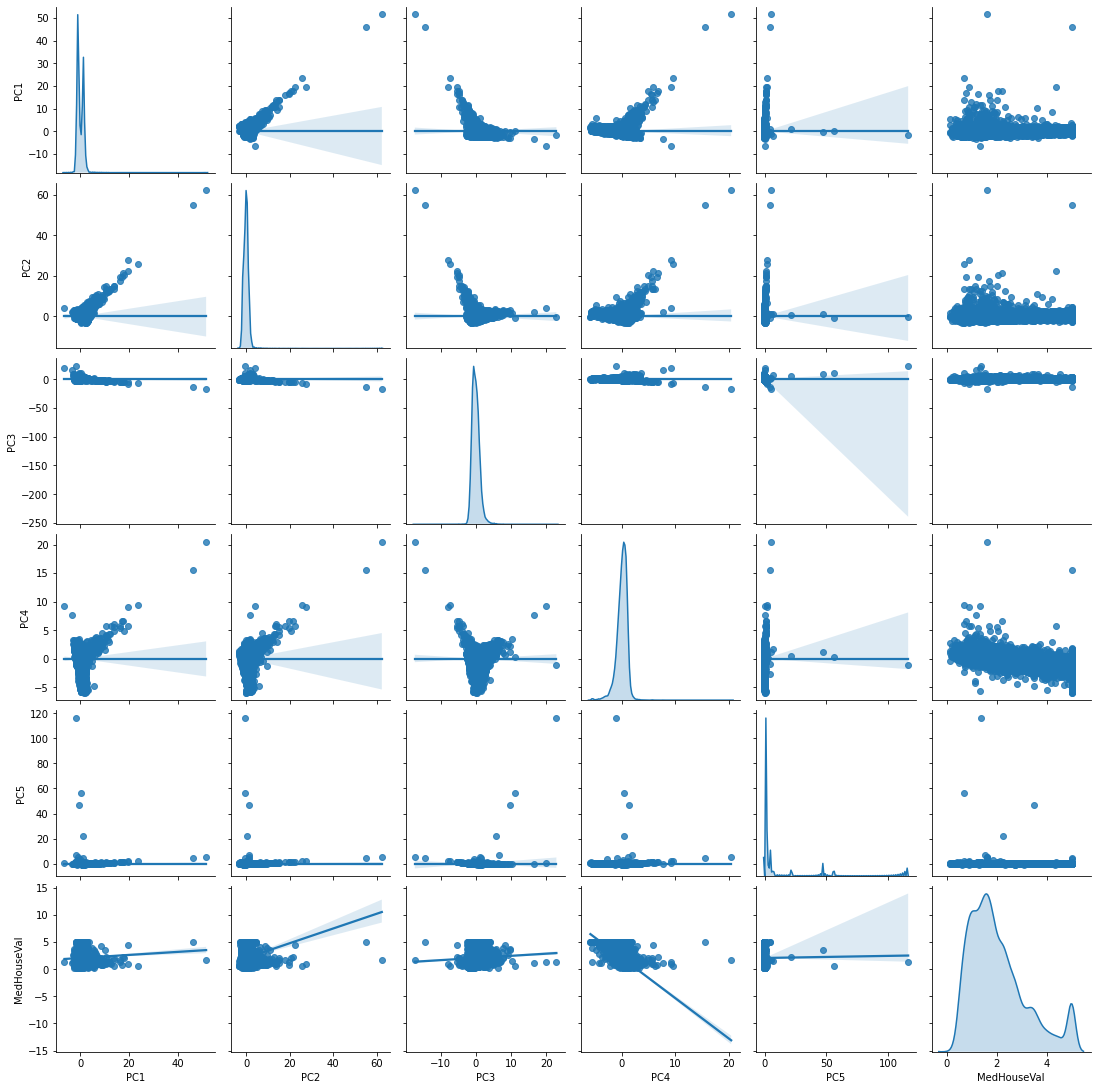

In [33]:
features_frame = pd.DataFrame(features, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
sns.pairplot(pd.concat([features_frame, Y], axis=1), kind='reg', diag_kind='kde')

## Data Distributions Examination
The above is a data distribution examination chart using seaborn. Some relationships observed are:
- The relationship between the Target and PC4 is high with an increase in PC4 leading to a decrease in the target.
- The relationship between the Target and PC2 is high with an increase in PC2 leading to a increase in the target.
- There is minimal relationship between Target and PC1, PC3 and PC5
- Most of the PCs are not directly related (low relationship) thus the dataset can be said to have minimal correlation

In [107]:
train_x, test_x, train_y, test_y = tts(features_frame, Y, test_size=0.3, random_state=101)

## Data Splitting
We split our data into train and test splits with test data being 30% of the total data. Then we did model selection as shown below.

In [117]:
result = {}
models = {'LinearRegression':lm.LinearRegression(),
          'Lasso':lm.Lasso(),
          'Ridge':lm.Ridge(),
          'ElasticNet':lm.ElasticNet()}

for i in models:
  regressor = models[i]
  if i is not 'LinearRegression':
      params = {'alpha': np.arange(0.01, 1, 0.001), 'max_iter': np.arange(1000, 10000, 100), 'tol': [0.001,0.0001,0.000001]}
      random = RSCV(regressor, param_distributions=params, n_jobs=-1)
      results = random.fit(train_x.copy(), train_y.copy())
      accuracy = results.score(test_x.copy(), test_y.copy())
  else:
    models[i].fit(train_x.copy(), train_y.copy())
    accuracy = models[i].score(test_x.copy(), test_y.copy())
  result[i]=[accuracy]
pd.DataFrame(result)

,LinearRegression,Lasso,Ridge,ElasticNet
0,0.262219,0.448309,0.262546,0.448811


## Model Selection and Randomized Hyperparameter Tuning
We paraded models Linear Regression, Lasso, Ridge and Elastic Net as our models. Using RandomizedSearchCV, we did hyperparameter tuning and got the above accuracy with the train-test split. The model with the highest accuracy was Elastic Net.

In [118]:
kfold1 = KFold(n_splits=2)
kfold2 = KFold(n_splits=4)
kfold3 = KFold(n_splits=6)
kfold4 = KFold(n_splits=8)
kfold5 = KFold(n_splits=10)
for i in models:
  regressor = models[i]
  cv1 = cvs(regressor, train_x.copy(), train_y.copy(), cv=kfold1)
  cv2 = cvs(regressor, train_x.copy(), train_y.copy(), cv=kfold2)  
  cv3 = cvs(regressor, train_x.copy(), train_y.copy(), cv=kfold3)  
  cv4 = cvs(regressor, train_x.copy(), train_y.copy(), cv=kfold4)  
  cv5 = cvs(regressor, train_x.copy(), train_y.copy(), cv=kfold5)  
  accuracy1 = cv1.mean()
  accuracy2 = cv2.mean()
  accuracy3 = cv3.mean()
  accuracy4 = cv4.mean()
  accuracy5 = cv5.mean()
  result[i]=[accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]
pd.DataFrame(result)

,LinearRegression,Lasso,Ridge,ElasticNet
0,0.444579,-0.000132,0.444716,0.174719
1,0.452365,-0.000210,0.452402,0.174389
2,0.451902,-0.000388,0.451937,0.174330
3,0.452893,-0.000248,0.452923,0.174472
4,0.452781,-0.000324,0.452810,0.174284


## K-Fold Cross Validation
By increasing the value of K in k-fold validation, the size of the training set increases. With data that has minimal outliers, an increase in k will lead to a higher accuracy while with data with many outliers the increase in k will not necessarily increase accuracy and will behave like above i.e accuracy will flactuate depending on the actual data that was used for training. This is probably because the data being included in the training data may or may not contain the outliers in question thus may increase or decrease accuracy.